## Model Training

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, confusion_matrix,
    roc_auc_score, precision_score, f1_score, roc_curve, auc
)
from sklearn.model_selection import learning_curve

pd.set_option('display.max_columns', 50)

In [19]:
# Load the processed dataset

data = pd.read_csv('/home/med/Desktop/Churn-Prediction-Project/src/data/processed/processed_data.csv')

data.head(5)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,No,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,45,0,No,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


### Churn Distribution

/tmp/ipykernel_3997366/2230634272.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=data, palette='Set2')


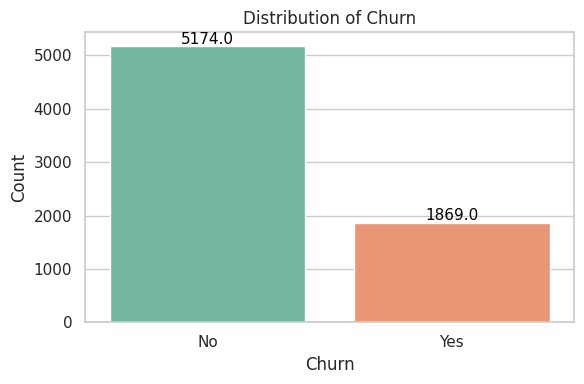

(7043, 19)

In [20]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data, palette='Set2')

plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
# Annotate the bars with exact counts
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.tight_layout()
plt.show()

data.shape

### Train/Test Split


In [40]:
# Train-test split
# Train 80% , Test 20%
# create a StratifiedShuffleSplit object
start_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)
train_index, test_index = next(start_split.split(data, data['Churn']))

# Create train and test sets
start_train_set = data.iloc[train_index]
start_test_set = data.iloc[test_index]

X_train = start_train_set.drop('Churn', axis=1)
y_train = start_train_set['Churn'].copy()

X_test = start_test_set.drop('Churn', axis=1)
y_test = start_test_set['Churn'].copy()

print(X_train.shape, X_test.shape)



(5634, 18) (1409, 18)


### Model Training

#### CatBoost (handles class imbalance and categorical features)

In [31]:
# Import catboost classifier
from catboost import CatBoostClassifier

In [38]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")

# Scale pos_weight based on class distribution
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
class_weights=[1, scale_pos_weight]

# Initialize CatBoostClassifier with class weights

model = CatBoostClassifier(
    verbose=False,
    random_state=0,
    scale_pos_weight=scale_pos_weight
)

# Train the model

model.fit(X_train, y_train, cat_features=categorical_columns)
# Make predictions
y_pred = model.predict(X_test)


Categorical columns: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [39]:
# Evaluate the model
accuracy, recall, roc_auc, precision = [round(metric(y_test, y_pred), 4) for metric in [accuracy_score, recall_score,roc_auc_score, precision_score]]

# Create a DataFrame to display the results

model_name = ['CatBoost_Model']
results = pd.DataFrame({'Accuracy': accuracy, 'Recal': recall, 'ROC_AUC': roc_auc, 'Precision': precision}, index=model_name)

print(results)

                Accuracy   Recal  ROC_AUC  Precision
CatBoost_Model    0.7885  0.7888   0.7886     0.5739


In [41]:
import os

# Save the model in the 'model' directory
model_dir = '../model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'catboost_model.cbm')
model.save_model(model_path)
print(f"Model saved to {model_path}")



Model saved to ../model/catboost_model.cbm
